# Transfrom 이해하기

In [43]:
import os
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
raw_path = "E:/공부/제로베이스/Part 10. 텐서플로 & Part 11. 파이토치/deeplearning_frameworks_zerobaseDSS/"

In [3]:
image = Image.open(raw_path + "datasets/sample.png")

np.array(image).shape

(321, 532, 4)

- 출력이 안됨..ㅎ

In [4]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

---
# Transfrom on Tensor

#### Resize
- functional 이라서 image는 인수로 입력

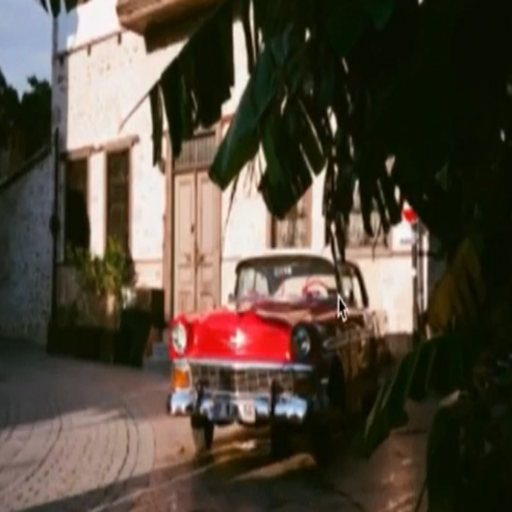

In [7]:
transforms.Resize((512, 512))(image)

#### RandomCrop
- 지정한 사이즈만큼, 위치는 random으로 잘라냄

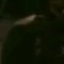

In [12]:
transforms.RandomCrop(size=(64, 64))(image)

#### ColorJitter
- 밝기 조절

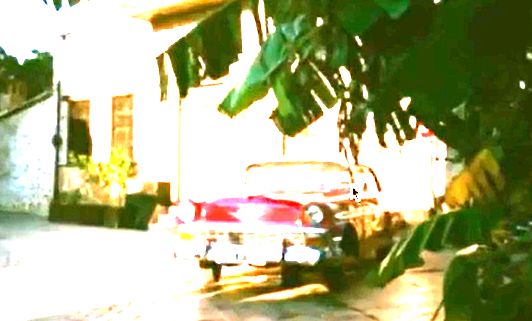

In [16]:
transforms.ColorJitter(brightness=4)(image)

#### Grayscale
- 흑백 변환

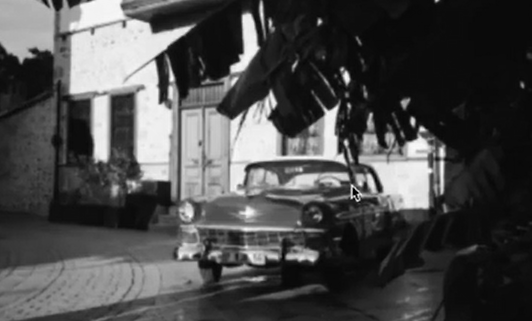

In [17]:
transforms.Grayscale()(image)

#### Pad
- 사진에 테두리 형성

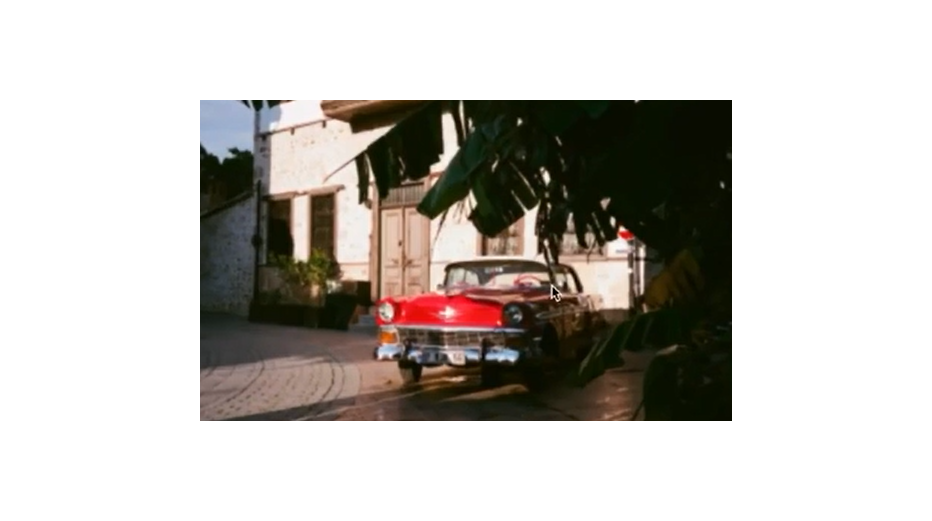

In [20]:
transforms.Pad(padding=(200, 100))(image)

#### RandomAffine
- 내가 지정한 각도로, 임의의 방향으로 회전

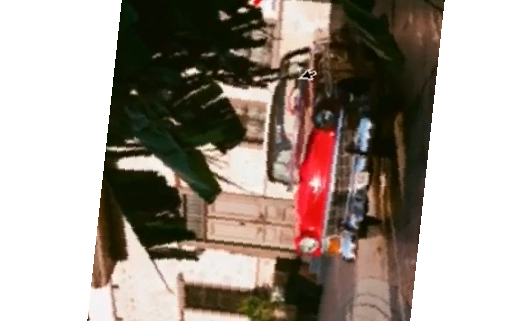

In [21]:
transforms.RandomAffine(degrees=90)(image)

#### RandomApply
- list에 있는 transforms기능을 random으로 적용
- 모두 적용, 하나만 적용, 모두 미적용 등 경우의 수 다 가능

In [22]:
transforms_list = [transforms.RandomAffine(degrees=90), transforms.Pad((20, 20))]

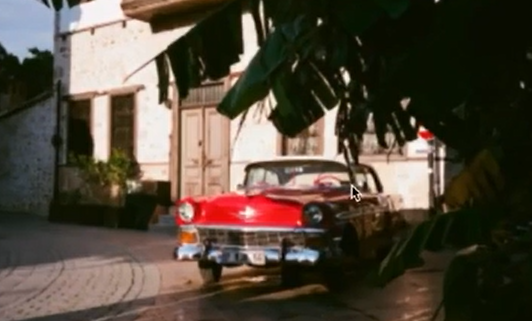

In [24]:
transforms.RandomApply(transforms_list, p=0.5)(image)

#### RandomChoice
- list에 있는 transforms기능 중 하나만 random으로 선택적용

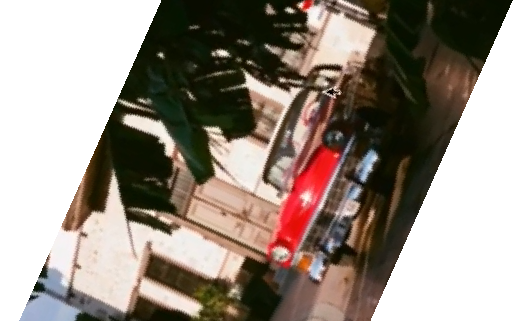

In [26]:
transforms.RandomChoice(transforms_list)(image)

#### RandomHorizontalFlip & RandomVerticalFlip

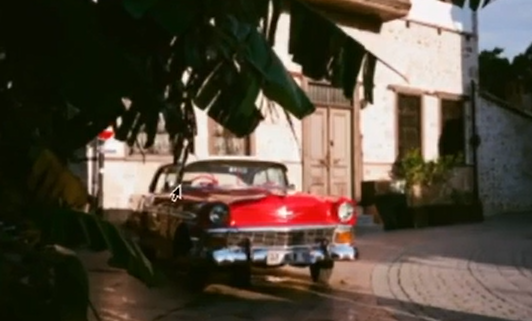

In [27]:
transforms.RandomHorizontalFlip(p=1)(image)

---
## Training Sample

In [32]:
raw_path = "E:/공부/제로베이스/Part 10. 텐서플로 & Part 11. 파이토치/deeplearning_frameworks_zerobaseDSS/"


cifar_dir = raw_path + "datasets/cifar/"
train_dir = os.path.join(cifar_dir , "train")
test_dir = os.path.join(cifar_dir , "test")

In [30]:
transform = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
                        transforms.Resize(224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

test_transform = transforms.Compose([
                    transforms.Resize(224), 
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

In [35]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_paths, transform=None):
        super(Dataset).__init__()
        self.data_paths = data_paths
        self.transform = transform
        
    def __len__(self): 
        return len(self.data_paths)
        
    def __getitem__(self, idx):  # 인덱스를 인수로 입력하면, 해당 인덱스를 이미지와 label로 만들어줌
        path = self.data_paths[idx]
        image = Image.open(path)
        label_name = path.split(".png")[0].split("_")[-1].strip()
        laebl = label_list.index(label_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image, laebl

In [36]:
train_dataset = Dataset(data_paths=glob(train_dir + "/*.png"), transform=transform)
test_dataset = Dataset(data_paths=glob(test_dir + "/*.png"), transform=test_transform)

In [37]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [47]:
with open(os.path.join(cifar_dir, "labels.txt"), 'r') as f:
    label_list = f.read().strip().split("\n")
    
label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ResidualBlock, self).__init__()
        
        self.in_channel, self.out_channel = in_channel, out_channel
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channel, out_channel, kernel_size=1, padding=0)
        
        if in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
            )
        else:
            self.shortcut = nn.Sequential()
    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out + self.shortcut(x)
        return out

class ResNet(nn.Module):
    def __init__(self, color='gray'):
        super(ResNet, self).__init__()
        if color == "gray":
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        elif color == "rgb":
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 64)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [49]:
model = ResNet(color='rgb')

In [50]:
optimizer = optim.Adam(model.parameters(), lr=0.03)
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)

def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    model.train()
    size = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss = loss.item()
            print(f"Epoch {epoch} : [{batch}/{size}] loss : {loss}")
            
    scheduler.step(loss)
    
    return loss.item()

def test_loop(dataloader, model, loss_fn, optimizer, epoch):
    model.eval()
    test_loss = 0
    
    with batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.nll_loss(output, y, reduction="sum").item()
        
    test_loss /= len(dataloader.dataset)
    return test_loss

In [51]:
for epoch in range(2):
    loss = train_loop(train_loader, model, F.nll_loss, optimizer, epoch)
    print(f"epoch:{epoch} loss:{loss}" )

Epoch 0 : [0/750] loss : 2.284353256225586
Epoch 0 : [100/750] loss : 2.3117828369140625
Epoch 0 : [200/750] loss : 2.3168625831604004
Epoch 0 : [300/750] loss : 2.3096542358398438
Epoch 0 : [400/750] loss : 2.2728374004364014
Epoch 0 : [500/750] loss : 2.3024892807006836
Epoch 0 : [600/750] loss : 2.3275277614593506
Epoch 0 : [700/750] loss : 2.311102867126465
epoch:0 loss:2.33164644241333
Epoch 1 : [0/750] loss : 2.3034186363220215


KeyboardInterrupt: 